# **Project 1 - Frequently Occuring Words**

This notebook aims to analyze the most frequently occurring unique words in the Trump and Biden datasets. It employs the Natural Language Toolkit (NLTK), a comprehensive suite of libraries and tools for symbolic and statistical natural language processing in English, to filter out "insignificant" words and perform lemmatization. Additionally, it leverages the Term Frequency-Inverse Document Frequency (TF-IDF) technique, a method in Natural Language Processing (NLP) that converts text into numerical features by measuring the importance of a word within a document relative to a larger collection of documents.

The main sections of this notebook are:

1. Word Processing: Utilized NLTK and TF-IDF to compute statistical measures that indicate the significance of specific words and phrases within the tweets for each candidate.

2. Data Visualization: Created imformative visualizations to display results of text analysis.

In [12]:
# import necessary packages
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# read in both csvs
trump_df = pd.read_csv("/content/trump_clean.csv")
biden_df = pd.read_csv("/content/biden_clean.csv")

<ipython-input-13-86fcebbaaf00>:2: DtypeWarning: Columns (0,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  trump_df = pd.read_csv("/content/trump_clean.csv")
<ipython-input-13-86fcebbaaf00>:3: DtypeWarning: Columns (0,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  biden_df = pd.read_csv("/content/biden_clean.csv")


In [14]:
# define list of U.S. state abbreviations to filter tweets by location
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
    'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
    'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
    'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
    'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

# filter each dataset to include only tweets from U.S. states
trump = trump_df.loc[trump_df['state_code'].isin(us_states)][['tweet']]
biden = biden_df.loc[biden_df['state_code'].isin(us_states)][['tweet']]

In [20]:
# function to preprocess/clean tweet for analysis
def preprocess_tweet(tweet):
    # create set of stopwords (common generic words that should be ignored in analysis)
    stopwords_set = set(stopwords.words('english'))
    # lemmatize words (i.e. walk = walking = walked = walks)
    wnl = WordNetLemmatizer()
    # ignore non-ascii characters, remove symbols
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()
    tweet = re.sub(r'[@_]|#.+|https?://\S+|[^\w\s]', '', tweet)
    processed_tweet = [wnl.lemmatize(word) for word in tweet.split() if word not in stopwords_set]
    return ' '.join(processed_tweet)

# preprocess both datasets
trump['cleaned_tweet'] = trump['tweet'].apply(preprocess_tweet)
biden['cleaned_tweet'] = biden['tweet'].apply(preprocess_tweet)

In [21]:
# combine dfs for TF-IDF vectorization
combined_tweets = pd.concat([trump['cleaned_tweet'], biden['cleaned_tweet']], axis=0)

# vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(combined_tweets)
feature_names = vectorizer.get_feature_names_out()

# convert TF-IDF matrix to df
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# split dfs back into trump and biden
trump_tfidf = tfidf_df[:len(trump)]
biden_tfidf = tfidf_df[len(trump):]

In [22]:
# function to find top N words with the highest avg TF-IDF score for each dataset
def get_top_n_words(tfidf_df, feature_names, n=100):
    top_n_words = tfidf_df.mean(axis=0).nlargest(n)
    return top_n_words.index.tolist(), top_n_words.values.tolist()

# get top 100 words with highest avg TF-IDF score
top_trump_words, top_trump_scores = get_top_n_words(trump_tfidf, feature_names, n=100)
top_biden_words, top_biden_scores = get_top_n_words(biden_tfidf, feature_names, n=100)

In [23]:
# remove common words between both dfs
unique_trump_words = list(set(top_trump_words) - set(top_biden_words))
unique_biden_words = list(set(top_biden_words) - set(top_trump_words))

print("Unique Trump words:", unique_trump_words)
print("Unique Biden words:", unique_biden_words)

Unique Trump words: ['didnt', 'antitrump', 'could', 'blue', 'read', 'potus', 'another', 'gop', 'stop', 'remember', 'anyone', 'lie', 'support', 'care', 'republican', 'believe']
Unique Biden words: ['call', 'first', 'bidens', 'presidential', 'watching', 'kamalaharris', 'work', 'democrat', 'poll', 'tonight', 'hope', 'congratulation', 'united', 'thank', 'hunter', 'ballot']


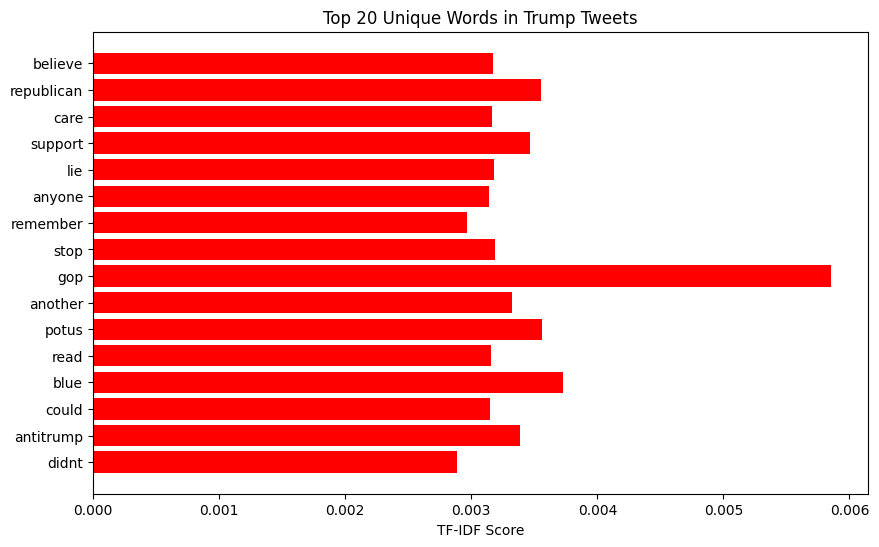

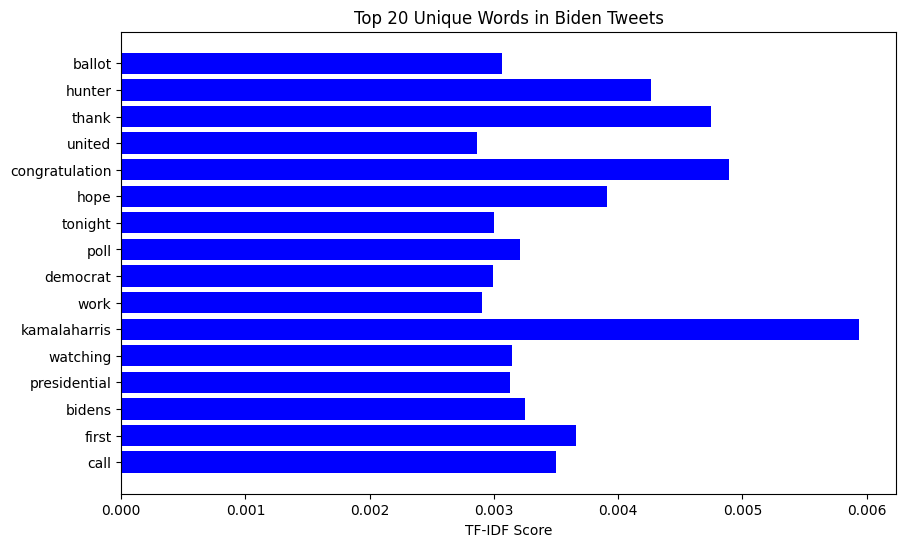

In [33]:
# function to plot word frequencies with a specified color
def plot_word_frequencies(words, frequencies, title, color):
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color=color)
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.show()

# create a dictionary of word -> score for plotting
unique_trump_scores = [top_trump_scores[top_trump_words.index(word)] for word in unique_trump_words]
unique_biden_scores = [top_biden_scores[top_biden_words.index(word)] for word in unique_biden_words]

# plot trump words in red
plot_word_frequencies(unique_trump_words[:20], unique_trump_scores[:20], 'Top 20 Unique Words in Trump Tweets', color='red')

# plot biden words in blue
plot_word_frequencies(unique_biden_words[:20], unique_biden_scores[:20], 'Top 20 Unique Words in Biden Tweets', color='blue')